# From Linear Regression to Deep Learning in Pytorch

---
---

# Linear Regression

Let's implement a simple linear regression using torch

In [1]:
import torch

To start with, we'll create some random data and store it as torch tensors. 

In [254]:
n = 100
p = 5
x = torch.randn(n, p) # predictors (100 observations, 5 features)
y = torch.randn(n, 1) # outcomes (100 observations)

We're looking for coefficients $\beta$ so that $y_i \approx x_i\beta = x_{i1}\beta_1 +x_{i2}\beta_2 \dots$. To quantify what we mean by a "good" approximation, we'll use the mean-squared-error loss. So for a given guess $\beta$ we'll give it the "grade" $\frac{1}{n}\sum_i (y_i - \hat y_i)^2$ where $\hat y_i  = x_i\beta$ and $n$ is the number of observations (rows) in the data. We're looking for the $\beta$ that gives us the best (lowest) grade.  This combination of model (linear) and loss (mean-squared-error) is called linear regression.

To start, we'll initialize the coefficients $\beta$ with random numbers. That's our first guess. We'll update these random numbers using gradient descent to iteratively find better values that make the loss smaller.

In [255]:
β = torch.randn(p, 1) # 5 coefficients (one per feature)
β.requires_grad_() # tell torch that β is going to have to save the gradient of something with respect to itself at some point

tensor([[-1.3404],
        [ 0.5450],
        [ 0.6492],
        [-0.5383],
        [ 0.7197]], requires_grad=True)

### Autograd

Using our current (random) coefficients we'll compute the current predictions and use those to compute the loss. That will be a relatively high number because our predictions won't be very good at this point. Once have the loss, we can use the torch autodifferentiation features to compute each of $\frac{\delta L}{\delta \beta_j}$, the gradients of the loss with respect to each coefficient, and use those to update the coefficients with gradient descent.

In [256]:
ŷ = torch.matmul(x, β) # ŷ = xβ

In [258]:
L = torch.sum((y-ŷ)**2)/n # L = Σ(yᵢ-ŷᵢ)²

In [259]:
L

tensor(4.2161, grad_fn=<DivBackward0>)

In [260]:
L.backward() # compute the gradients of the loss with respect to any tensors that went into the loss with requires_grad=true

In [261]:
β.grad

tensor([[-2.7066],
        [ 0.8172],
        [ 1.6938],
        [-1.1461],
        [ 1.0480]])

what we see here is a vector containing all of the derivatives we want. The first element is $\frac{\delta L}{\delta \beta_1}$, the second element is $\frac{\delta L}{\delta \beta_2}$, and so on. Note that this object is part of $\beta$ and not $L$.

Let's calculate the gradient manually and make sure it matches up. We have:

$$
\begin{array}{rcl}
\hat y_i &=& x_i\beta\\
L(y,\hat y) &=& \frac{1}{n}\sum_i (y_i - \hat y_i)^2
\end{array}
$$

So the derivative is

$$
\begin{array}{rcl}
\frac{\partial L}{\partial \beta_j} &=& 
\frac{1}{n}
\sum_i 
\frac{\partial L}{\partial y_i} 
\frac{\partial y_i}{\partial \beta_j}
\\
&=&
\frac{1}{n}
\sum_i
-2(y_i-\hat y_i)
x_{ij}
\\
&=&
-\frac{2}{n}
x_j^T(y-\hat y)
\end{array}
$$

which means we can calculate the whole gradient as $-\frac{2}{n}x^T(y-x\beta)$

In [265]:
def beta_grad(β):
    return -2*torch.matmul(x.transpose(0,1), y-torch.matmul(x,β))/n

In [266]:
beta_grad(β)

tensor([[-2.7066],
        [ 0.8172],
        [ 1.6938],
        [-1.1461],
        [ 1.0480]], grad_fn=<DivBackward0>)

which is exactly the same as the result in `β.grad`!

How does pytorch do this? It turns out that every pytorch tensor records not only its own value, but also what functions were called to produce it and which tensors went into those functions. The `torchvis` package lets us see this:

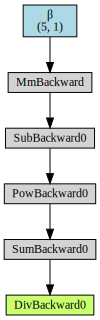

In [267]:
from torchviz import make_dot
make_dot(L, {'β':β})

To calculate the gradient of $L$ with respect to $\beta$, pytorch takes the gradients of each of these functions in turn (which are simple and built-in to pytorch), evaluates them at their current value using the input tensors, and multiplies them together to arrive at the answer you would get via the chain rule. You can learn more about this process [here](https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95) and elsewhere.

### Doing Gradient Descent

To update the weights, we need to subtract the gradient (times a small learning rate) from the current value of the weights. 

We do this from inside a `no_grad():` "context" so that $\beta$ doesn't store the history of the update (try the update without the `with torch.no_grad():` and see what happens). We also clear out `β.grad`. 

In [268]:
with torch.no_grad():
    β -= 10e-5 * β.grad # β = β - 10e-5 * β.grad
    β.grad.zero_()

In [269]:
β

tensor([[-1.3401],
        [ 0.5449],
        [ 0.6491],
        [-0.5382],
        [ 0.7195]], requires_grad=True)

As you can see, our new value of $\beta$ is slightly different than what we started with because we've taken a single gradient step.

----

#### Zeroing Gradients

Let's take a quick second to diverge from our main story to explain why we need to zero the gradient. If we don't zero the gradient, the next time we calculate the gradient of something with respect to $\beta$, the new gradient will be added to whatever was stored there instead of overwriting it. That's just the way torch was made to work. To demonstrate:

In [270]:
t = torch.tensor(5., requires_grad=True)
z = t**2 # z = t^2
z.backward() # dz/dt = 2t, and t =5 right now
t.grad # so dz/dt = 2*5 = 10

tensor(10.)

all good so far... Now let's make another variable based on $t$

In [271]:
q = t**3 # q = t^3
q.backward() # dq/dt = 3t^2, and t=5 right now
t.grad # so dq/dt = 3*5^2 = 75

tensor(85.)

Here we should have gotten 75, but we got 85, which is 75 + 10. What happened was that 10 was previously stored in `t.grad`, so it got added to the new number that came in when we called `q.backward()`.

----

Ok, back to our main story. Let's repeat what we have so far but now add a little loop to train our model for 500 gradient descent iterations instead of going slowly though a single iteration:

In [281]:
x = torch.randn(100, 5) # predictors (10 observations, 5 features)
y = torch.randn(100, 1) # outcomes (10 observations)

loss_record = [] # to kep track of the loss over the iterations
β = torch.randn(5,1) # 5 coefficients (one per feature)
β.requires_grad_() # tell torch that β is going to have to save the gradient of something with respect to itself at some point

tensor([[-0.3821],
        [ 0.9374],
        [-1.8131],
        [ 0.7774],
        [-0.7328]], requires_grad=True)

In [282]:
for e in range(500):
    ŷ = torch.matmul(x, β) # ŷ = xβ (calculate predictions)
    L = torch.sum((y-ŷ)**2)/n # L = Σ(yᵢ-ŷᵢ)² (use predictions to calculate loss)
    
    L.backward() # compute gradients (in this case δL/δβ, δL/δW)
    loss_record.append(L.item())
    
    with torch.no_grad(): # take the gradient descent step 
        β -= 10e-3 * β.grad
        β.grad.zero_()

And we can see how the loss changes over the iterations:

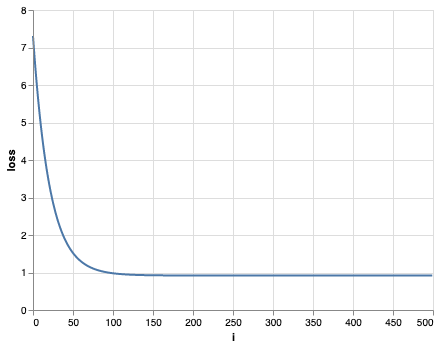

In [283]:
import altair as alt
import pandas as pd

loss_df = pd.DataFrame({'i':range(500), 'loss':loss_record})
alt.Chart(loss_df).mark_line().encode(x='i', y='loss')

We see training loss goes down.

And here's the value of $\beta$ after 500 iterations:

In [284]:
β

tensor([[ 0.0900],
        [-0.0986],
        [-0.1356],
        [-0.0855],
        [ 0.0450]], requires_grad=True)

Remember our original data is totally random and there is no relationship between the predictors and outcomes. So the "right" answer for what $\beta$ should be in this case is $\beta=0$. As we see above, all the values are near 0, so our algorithm appears to be converging to the right answer.

To predict for a new observation, all we have to do is multiply by $\beta$:

In [285]:
new_x = torch.randn(10, 5) # 10 new observations
torch.matmul(new_x, β) # predictions

tensor([[-0.0175],
        [ 0.0421],
        [ 0.2226],
        [ 0.1352],
        [-0.3951],
        [-0.1273],
        [-0.0518],
        [ 0.0392],
        [-0.1468],
        [-0.1083]], grad_fn=<MmBackward>)

### Conclusion

We just developed a machine learning method out of these three components:
* linear model (model)
* MSE loss (loss)
* gradient descent (search algorithm)

These components are like interchangable parts. We're going to see how we can use a different model and loss to fit data of a different kind without fundamentally changing our search strategy.

# Logistic Regression

Now that we've seen how this works for linear regression, we can try and implement a model that predicts probabilities for a two-class outcome instead of a prediction for a continuous outcome. Now our data look like this:

In [286]:
n,p = 100,5
x = torch.randn(n,5) # predictors (10 observations, 5 features)
y = torch.randint(0,2,(n,), dtype=torch.float) # outcomes (10 observations)

In [287]:
y[0:5]

tensor([0., 0., 0., 1., 1.])

## Changing the model

To do this, we have to change two things: firstly, our model can't be $\hat y_i  = x_i\beta$ anymore because $\hat y_i$ will come out as a number between plus and minus infinity, wheras we now want it to be a number between 0 and 1 (a probability). To fix this, we'll apply a function that takes $x_i\beta$ and squishes it down to a number between 0 and 1. The function we'll use is $\sigma(z) = \frac{1}{1+e^{-z}}$, which is called the *sigmoid* or *logistic* function. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/600px-Logistic-curve.svg.png)

So our model will be $\hat p_i  = \sigma(x_i\beta)$. The parameters are still $\beta$, but now there is an additional (fixed) squishing function that makes sure the output is a probability. In accordance, I've called the output $\hat p_i$ instead of $\hat y_i$.

## Changing the loss

Our loss function from before was MSE: $\sum (\hat y_i - y_i)^2$, which compares a predicted outcome to the true outcome. One option is to replace the predicted outcome with a predicted probability to get $\sum (\hat p_i - y_i)^2$ (the _Brier Score_). Here's what that looks like (for a single observation $i$):

![](http://journal.sjdm.org/16/16218/jdm16218001.png)

This is ok, but many people don't like that there is a maximum penalty under this loss: if the true outcome was $y_i =0$ but the model predicts $p_j = P(Y_i=1) = 1$ (i.e. $y_i =1$ with absolute certainty), then the penalty should be infinitely high to strongly discrourage this kind of overconfident (wrong) prediction. Under the Brier score, however, you can see that this kind of prediction only incurrs a loss of 1, not infinity. Furthermore, when the outcome is 1 and the prediction gets closer and closer to 1, we see that the loss "flattens out", which means that we're not encouraged to be more and more confident when we're right.

What we want is a loss function that looks like this:

![](https://conorsdatablog.files.wordpress.com/2018/03/log_loss.png?w=615&h=597)

This is called the _log-loss_ (or _cross-entropy loss_ or _binomial deviance_). It is expressed as 

$$
L(\hat p, y) = 
\frac{1}{n}
\sum_i 
\begin{cases}
-\log(P(Y_i = 1)) & \text{if}\ y_i=1 \\
-\log(P(Y_i = 0)) & \text{if}\ y_i=0
\end{cases}
$$

which is the same as 

$$
=
\frac{1}{n}
\sum_i 
\begin{cases}
-\log(\hat p_i) & \text{if}\ y_i=1 \\
-\log(1-\hat p_i) & \text{if}\ y_i=0
\end{cases}
\\
= 
-\frac{1}{n}
\sum_i 
y_i \log(\hat p_i) + (1-y_i) \log (1-\hat p_i)
$$

## Search strategy is still gradient descent

This combination of logistic-linear model and log-loss is called _logistic regression_ (although this is a misnomer because we're actually doing classification, not regression). The amazing thing about gradient descent is that, as long as you can differentiate through the loss and to the model parameters, it just works. Compare this code to what we did to fit our linear regression model.

In [294]:
x = torch.randn(100, 5) # predictors (10 observations, 5 features)
y = torch.randint(0,2,(n,), dtype=torch.float) # outcomes (10 observations)

loss_record = [] # to kep track of the loss over the iterations
β = torch.randn(5,1) # 5 coefficients (one per feature)
β.requires_grad_() # tell torch that β is going to have to save the gradient of something with respect to itself at some point

tensor([[ 0.0201],
        [-0.5079],
        [-1.4797],
        [-0.1254],
        [ 1.5459]], requires_grad=True)

In [295]:
for e in range(500):
    z = torch.matmul(x, β) 
    p̂ = torch.exp(-z)/(1+torch.exp(-z))
    L = -torch.sum(torch.log(p̂)*y + torch.log(1-p̂)*(1-y))/n # log loss
    
    L.backward() # compute gradients (in this case δL/δβ, δL/δW)
    loss_record.append(L.item())
    
    with torch.no_grad(): # take the gradient descent step 
        β -= 10e-4 * β.grad
        β.grad.zero_()

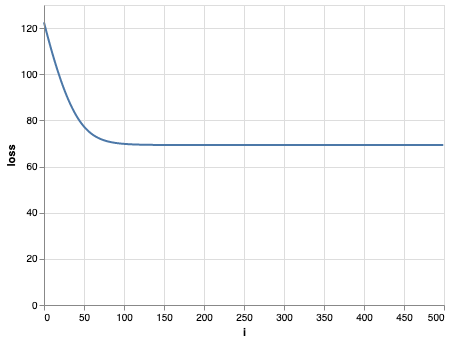

In [296]:
loss_df = pd.DataFrame({'i':range(500), 'loss':loss_record})
alt.Chart(loss_df).mark_line().encode(x='i', y='loss')

Although the code looks pretty much the same, save the changes to the model and loss, the computation that pytorch needs to do to compute the gradient of $L$ with respect to each $\beta$ is now much more involved, which you too will see if you try to compute it by hand:

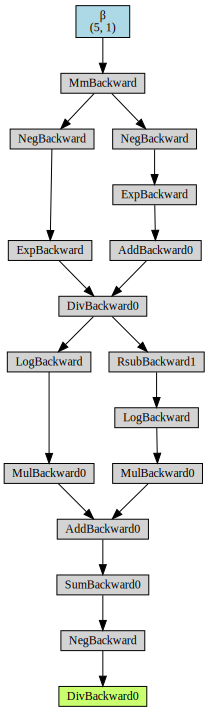

In [297]:
make_dot(L, {'β':β})

The amazing thing is that pytorch just handles it and you don't have to.

<div class="alert alert-block alert-info">
<b>Exercise:</b> 

Why don't we use *accuracy* as a loss? In other words,
    
$$
L(y, \hat p) = \sum_i
\begin{cases}
1 & \text{if}\ y_i = 1 \ \text{and} \ \hat p_i > 0.5 \\
1 & \text{if}\ y_i = 0 \ \text{and} \ \hat p_i \le 0.5 \\
0 & \text{else}
\end{cases}
$$
    
*Hint*: what is the derivative of this loss with respect to any prediction $\hat p_i$?
</div>

To predict for a new observation, all we have to do is multiply by $\beta$ and pass through $\sigma$:

In [298]:
new_x = torch.randn(10, 5) # 10 new observations
z = torch.matmul(new_x, β) 
torch.exp(-z)/(1+torch.exp(-z)) # probability predictions

tensor([[0.5041],
        [0.5064],
        [0.4986],
        [0.4825],
        [0.5130],
        [0.5108],
        [0.5080],
        [0.4913],
        [0.5045],
        [0.4944]], grad_fn=<DivBackward0>)

### Conclusion

We just developed a machine learning method out of these three components:
* linear-logistic model (model)
* log loss (loss)
* gradient descent (search algorithm)

This should make it clear to you that gradient descent is a widely-applicable strategy that will work with any loss or model, as long as you can define derivatives of the loss with respect to the model parameters. We will now go back to our linear regression example, but augment the model with more parameters and a more complex structure in order to capture nonlinear relationships. 

# Adding complexity to our linear model

Let's go back to our regression example.

In [301]:
p = 5 
n = 100

x = torch.randn(n, p) # predictors (n observations, p features)
y = torch.randn(n, 1) # outcomes (n observations)

In [302]:
loss_record = [] 
β = torch.randn(5,1) 
β.requires_grad_() 

for e in range(500):
    ŷ = torch.matmul(x, β) 
    L = torch.sum((y-ŷ)**2)/n 
    
    L.backward() # compute gradients (in this case δL/δβ, δL/δW)
    loss_record.append(L.item())
    
    with torch.no_grad(): # take the gradient descent step 
        β -= 10e-5 * β.grad
        β.grad.zero_()

Remember that the linear model is $\hat y =x\beta$. Let's say we want to add some complexity to this model by figuring out if there are some other predictors we can build (call them $z$) that are a transformation of the predictors $x$ that are better for predicting $y$ in a linear model than $x$ is. To do that, we'll first let $z = g(xW)$ with $W$ being a $p \times h$ matrix so each row of $z$ ends up with $h$ columns and $g$ is an element-wise ReLU function. The purpose of $W$ is to make $h$ predictors out of our original $p$ using a linear transformation. The purpose of $g$ is to add complexity to the model.

Now our final model is a linear model done on the new predictors $z$. That model is $\hat y =z\alpha$. I'm calling the coefficient vector $\alpha$ because now this needs $h$ coefficients for each of the $h$ new features, whereas $\beta$ was a $p$-length vector. So, in full, our model is now $\hat y = g(xW)\alpha$. We decided that $g$ should be the ReLU function, but instead of us deciding what the values of $W$ should be to create our new predictors $z$, we'll use gradient descent so that the model can build the predictors that it finds the most useful at the same time that it is using gradient descent to find the coefficients $\alpha$ that maximize the utility of these predictors. Thus this model has $h\times p + h$ total parameters (the values of $W_{ij}$ and $\beta_j$) to be fit, whereas our original linear model only had $p$ parameters.  

Without the ReLU (or some nonlinear function), there is always a vector $\beta$ such that $x\beta = xW\alpha$ for every $W$ and $\alpha$ (in fact, it's the vector $\beta = W\alpha$). In effect, adding the transformation $W$ doesn't actually add anything to the model- we're expanding the number of parameters to fit without actually expanding the expressivity of the model because there is always a model  with fewer parameters ($x\beta$) that perfectly captures the predictions of the over-parametrized model ($xW\alpha$). That is why the nonlinearity $g$ is necessary.

Let's dig into this, one step at a time. First we'll investigate the transformation $xW$. As we said, we're trying to build new features from our old features, so let's look at just one of these new features, $z_1$:

$$ 
z_1 
=
\left[
\begin{array}{c}
z_{11} \\ z_{12} \\ \vdots \\ z_{1n}
\end{array}
\right]
=
g\left(
\left[
\begin{array}{c}
x_{11} & x_{21} & \cdots & x_{p1} \\
x_{12} & x_{22} & \cdots & x_{p2} \\
\vdots & \vdots & \ddots & \vdots \\
x_{1n} & x_{2n} & \cdots & x_{pn}
\end{array}
\right]
\left[
\begin{array}{c}
w_{11} \\ w_{12} \\ \vdots \\ w_{1p}
\end{array}
\right]
\right)
$$

Or, concisely, $z_1 = g(xw_1)$. Without $g$, this looks just like a linear model of $z_1$ based on predictors $x$ and coefficients $w_1$. The other transformed features will be the same: $z_j = g(xw_j)$. So one way to look at this is that we're doing $h$ "$g$-linear" regressions (assuming we have $W$) and getting their predictions. The matrix equation $z = g(xW)$ expresses all of these "regressions" simultaneously.

In [303]:
from torch.nn.functional import relu as g
h = 10
W = torch.randn(5, h).requires_grad_()

In [304]:
z = g(torch.matmul(x,W))
z.shape

torch.Size([100, 10])

As you see, we're getting 100 observations of 10 "features". Let's look at one of them:

In [305]:
z[0:10,1]

tensor([0.0000, 0.5713, 4.2586, 2.7537, 2.3508, 4.2390, 5.8705, 2.0447, 0.1807,
        0.0000], grad_fn=<SelectBackward>)

We could also have done them one-at-a-time:

In [306]:
w1 = W[:,1]
z1 = g(torch.matmul(x,w1))

In [307]:
z1[0:10]

tensor([0.0000, 0.5713, 4.2586, 2.7537, 2.3508, 4.2390, 5.8705, 2.0447, 0.1807,
        0.0000], grad_fn=<SliceBackward>)

Same thing. 

The outputs of those regressions ($z$) are our new predictors in the next stage of the model, which is a single linear regression $\hat y = z\alpha$.

In [308]:
α = torch.randn(h,1).requires_grad_()
ŷ = torch.matmul(z,α)

And, finally, we can compute our MSE loss:

In [309]:
L = torch.sum((y-ŷ)**2)/n
L

tensor(2.9444, grad_fn=<DivBackward0>)

Let's look at the compuational graph we've built:

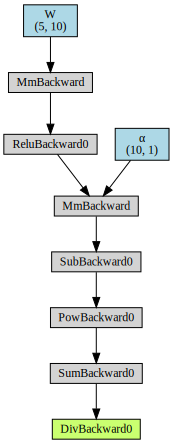

In [310]:
make_dot(L, {'W':W, 'α':α})

Now $L$ depends both on what $W$ is and on what $\alpha$ is. In other words, both of these sets of coefficients are parameters of the model that we can tweak and optimize. $W$ determines what kinds of "new predictors" we get out $x$, while $\alpha$ puts those new features together into the final prediction. What's amazing is that we can fit all of these parameters simultaneously using gradient descent: just update both sets of parameters using the negative gradient at each step. 

Furthermore, this poses no problem for pytorch:

In [311]:
L.backward()

In [312]:
α.grad

tensor([[ 0.7680],
        [ 0.3139],
        [-1.2842],
        [-1.0303],
        [ 1.1569],
        [ 0.5958],
        [-0.5456],
        [-1.0524],
        [ 2.0063],
        [ 1.8544]])

In [313]:
W.grad

tensor([[ 1.1687e-01, -5.0605e-03,  6.3030e-02, -1.3480e-01,  1.5509e-02,
         -3.1528e-01,  2.3328e-01,  7.2360e-02, -4.0134e-01,  3.0114e-02],
        [ 1.3495e-01, -1.5010e-01,  6.9610e-04, -3.2520e-01,  1.1567e-01,
         -2.7157e-01,  2.3883e-01,  3.3559e-01, -6.6528e-01,  1.4963e-01],
        [-1.5859e-01,  2.5824e-01, -1.0168e-01,  5.8844e-01, -1.6707e-01,
          6.8210e-01, -2.7112e-01, -9.8352e-01,  1.1354e+00, -2.1367e-01],
        [-7.8774e-02,  1.4069e-02, -4.2660e-02,  4.4790e-03,  1.0199e-02,
          7.2061e-02, -2.0986e-01, -4.9705e-02,  1.5812e-01,  3.6534e-02],
        [-3.3333e-01,  1.1583e-01, -1.2916e-01,  2.1420e-01, -9.2675e-02,
          1.5991e-01, -5.8191e-01, -1.9934e-01,  1.2363e+00, -1.2004e-01]])

### Looping

As before, now that we have gone through this once, we can put it all together into a loop:

In [320]:
p = 5 
n = 100

x = torch.randn(n, p) # predictors (n observations, p features)
y = torch.randn(n, 1) # outcomes (n observations)

In [321]:
h = 10
W = torch.randn(5, h).requires_grad_()
α = torch.randn(h, 1).requires_grad_()
loss_record = []

for e in range(500):
    z = g(torch.matmul(x,W))
    ŷ = torch.matmul(z,α)
    L = torch.sum((y-ŷ)**2)/n
    
    L.backward() # compute gradients (in this case δL/δα, δL/δW)
    loss_record.append(L.item())
    
    with torch.no_grad(): # take the gradient descent step 
        α -= 10e-3 * α.grad
        α.grad.zero_()
        W -= 10e-3 * W.grad
        W.grad.zero_()

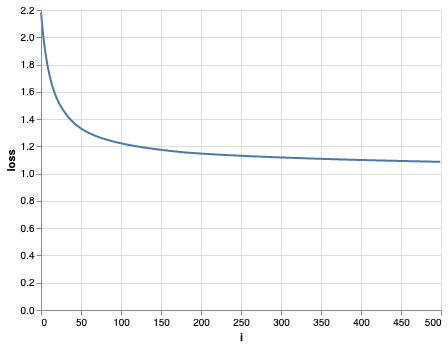

In [322]:
loss_df = pd.DataFrame({'i':range(500), 'loss':loss_record})
alt.Chart(loss_df).mark_line().encode(x='i', y='loss')

And here are our predictions for a new $x$:

In [323]:
new_x = torch.randn(10, 5) # 10 new observations
z = g(torch.matmul(new_x,W))
torch.matmul(z,α)

tensor([[ 0.3409],
        [-0.3684],
        [-0.2525],
        [ 0.6195],
        [-0.0507],
        [-1.0138],
        [-0.0835],
        [-0.2314],
        [-0.0812],
        [-0.2056]], grad_fn=<MmBackward>)

<div class="alert alert-block alert-info">
<b>Exercise:</b> 

Apply this strategy to our logistic regression to make a more complex **classification** model. In other words, implement the machine learning algorithm with these characteristics:
* Model: $\hat p_i = \sigma(g(x_i W))\alpha)$, with $\sigma$, $g$, $W$, and $\alpha$ as previously described
* Loss: log-loss
* Search Algorithm: gradient descent
</div>

### Conclusion

We just developed a machine learning method out of these three components:
* "linear-relu" $\times$ 10 + linear model (model)
* MSE loss (loss)
* gradient descent (search algorithm)

This is a neural network. The 10 "new predictors" are together a _hidden layer_ (hidden because we don't see them at the end of the day, just the output $\hat y$) and each of them individually is called a _hidden unit_. The function $g$ is called an _activation function_, so in total what we've built is a neural network with a single size-10 hidden layer and a ReLU activation function. We then fit that model using gradient descent and an MSE loss.

## How does this help?

While we could define ever-more complex interactions of parameters and data, it turns out that simply stacking linear regressions with nonlinear activation functions on top of each other (e.g. "linear-relu" regressions) gets us enough complexity to model practically any relationship we want. Let's have a look at an example where $y = x^2$ in reality:

In [391]:
p = 1
n = 100

x = torch.randn(n, p) # predictors (n observations, p features)
y = x[:,0]**2 # outcomes (n observations)

If we fit a linear model, we don't do very well:

In [385]:
loss_record = [] 
β = torch.randn(p,1).requires_grad_()

for e in range(500):
    ŷ = torch.matmul(x, β) # ŷ = xβ (calculate predictions)
    L = torch.sum((y-ŷ)**2)/n # L = Σ(yᵢ-ŷᵢ)² (use predictions to calculate loss)
    
    L.backward() # compute gradients (in this case δL/δβ, δL/δW)
    loss_record.append(L.item())

    with torch.no_grad(): # take the gradient descent step 
        β -= 10e-5 * β.grad
        β.grad.zero_()

The loss does go down, but overall it's still really high:

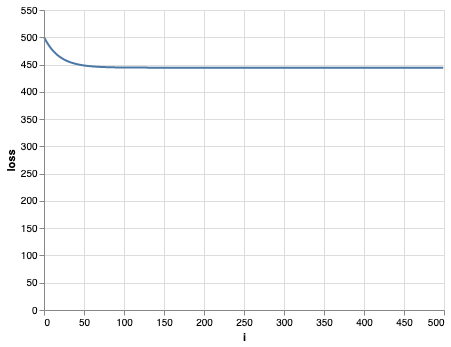

In [386]:
loss_df = pd.DataFrame({'i':range(500), 'loss':loss_record})
alt.Chart(loss_df).mark_line().encode(x='i', y='loss')

And when we plot the model predictions against reality we see how bad it is:

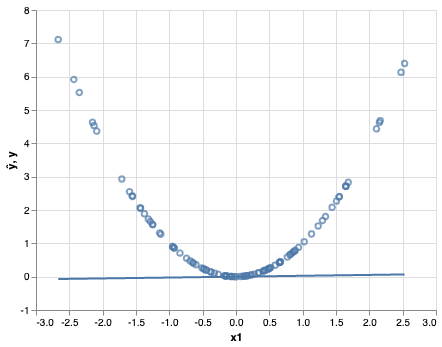

In [387]:
preds = pd.DataFrame({'ŷ':ŷ.detach().numpy()[:,0], 'y':y, 'x1':x[:,0]})
(alt.Chart(preds).mark_line().encode(x='x1', y='ŷ') + 
alt.Chart(preds).mark_point().encode(x='x1', y='y'))

However, we can introduce a hidden layer (of size 10):

In [401]:
h = 10
W = torch.randn(p, h).requires_grad_()
α = torch.randn(h, 1).requires_grad_()
loss_record = []

for e in range(500):
    z = g(torch.matmul(x,W))
    ŷ = torch.matmul(z,α)
    L = torch.sum((y-ŷ)**2)/n # L = Σ(yᵢ-ŷᵢ)² (use predictions to calculate loss)
    
    L.backward() # compute gradients (in this case δL/δα, δL/δW)
    loss_record.append(L.item())
    
    with torch.no_grad(): # take the gradient descent step 
        α -= 10e-5 * α.grad
        α.grad.zero_()
        W -= 10e-5 * W.grad
        W.grad.zero_()

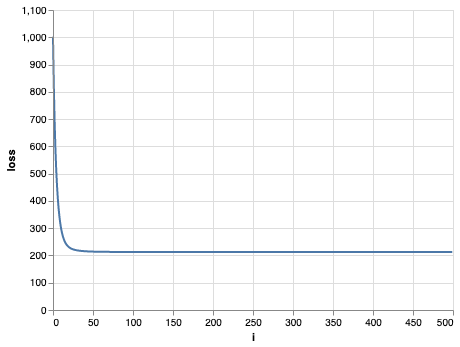

In [402]:
loss_df = pd.DataFrame({'i':range(500), 'loss':loss_record})
alt.Chart(loss_df).mark_line().encode(x='i', y='loss')

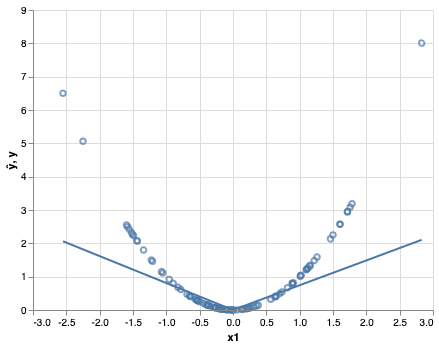

In [403]:
preds = pd.DataFrame({'ŷ':ŷ.detach().numpy()[:,0], 'y':y, 'x1':x[:,0]})
(alt.Chart(preds).mark_line().encode(x='x1', y='ŷ') + 
alt.Chart(preds).mark_point().encode(x='x1', y='y'))

And now the loss is lower and the fit is clearly much improved. 

### Conclusion

We saw how we can get a nonlinear fit out of stacking linear models and nonlinear activation functions together.

# Abstracting the "Layer"

Since we'll be stacking layers of arbitrary size arbitrarily deep, we might as well abstract away some of the code we need so we don't have to keep track of all the parameters in the model.

We'll first define a `LinearLayer` class that transforms a representation of size `h1` to one of size `h2`.

In [488]:
class LinearLayer():
    def __init__(self, h1, h2):
        self.W = torch.randn(h1,h2).requires_grad_()
    
    def __call__(self, x):
        return torch.matmul(x, self.W)

And now we can stack up as many of these as we want

In [489]:
from torch import sigmoid

In [496]:
s[:-1]

[1, 10]

In [497]:
from torch.nn.functional import relu

class Model():
    def __init__(self, sizes):
        sizes_shifted = sizes[1:] + [1]
        self.layers = [LinearLayer(h1,h2) for h1, h2 in zip(sizes, sizes_shifted)]
        self.activation = relu
    
    def __call__(self,x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x)) # 5 relu regressions
        return self.layers[-1](x)

check it out:

In [516]:
n= 100
p = 1

x = torch.randn(n, p) # predictors (n observations, p features)
y = x[:,0]**2 # outcomes (n observations)

my_model = Model([1,10,5,10,100])
L = torch.sum((y - my_model(x))**2)/n

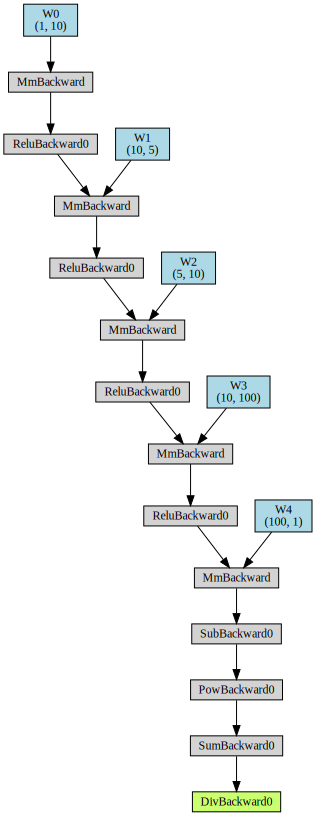

In [517]:
params = {f'W{k}':layer.W for k,layer in enumerate(my_model.layers)}
make_dot(L, params)

In [500]:
import numpy as np

In [556]:
my_model = Model([1,100,10,1])

n_steps = 1000
ϵ = 0.2*10e-7
loss_record = []

for e in range(n_steps):
#     index = np.random.choice(n, int(np.floor(n/2)), replace=False)
#     xx, yy = x[index,:], y[index]
    ŷ = my_model(x) 
    L = torch.sum((y-ŷ)**2)/len(ŷ)
    
    loss_record.append(L.item())
    L.backward()
    
    with torch.no_grad(): # take the gradient descent step 
        for layer in my_model.layers:
            layer.W -= ϵ * layer.W.grad
            layer.W.grad.zero_()        

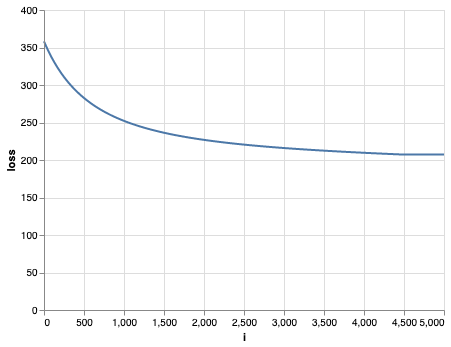

In [552]:
loss_df = pd.DataFrame({'i':range(n_steps), 'loss':loss_record})
alt.Chart(loss_df).mark_line().encode(x='i', y='loss')

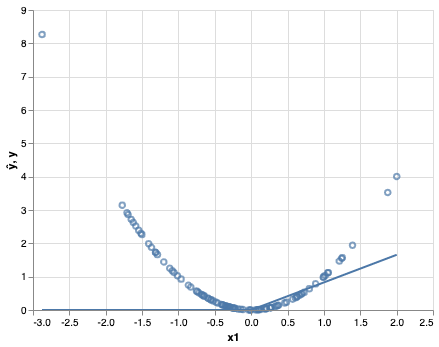

In [557]:
preds = pd.DataFrame({'ŷ':my_model(x).detach().numpy()[:,0], 'y':y, 'x1':x[:,0]})
(alt.Chart(preds).mark_line().encode(x='x1', y='ŷ') + 
alt.Chart(preds).mark_point().encode(x='x1', y='y'))